## Tight-binding modelling of the Breathing Kagome System
### Here, we will follow the paper by Nagosa and Bolens "PhysRevB.99.165141" on the Breathing kagome system with trimerized couplings. 

In [1]:
using LinearAlgebra
using Makie 
using CairoMakie 
using Brillouin
using Printf
using PlotlyJS
using Symbolics
using StaticArrays

### Basis and Lattice geometry. 

Note that R1 and R2 are the basis in real space. They are related by a C_3 rotation. To complete the orbit of the C_3 group, we also define R3. R1, R2, and R3 show up in the momentum-space Hamiltonian 

--- Plotting the Wigner-Seitz cell in real space. 

--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): 
  0.666667   0.333333 
  0.333333  -0.333333 
 -0.333333  -0.666667 
 -0.666667  -0.333333 
 -0.333333   0.333333 
  0.333333   0.666667 

--- Plotting the Wigner-Seitz cell in reciprocal space. 

--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): 
 -0.666667   0.333333 
 -0.333333   0.666667 
  0.333333   0.333333 
  0.666667  -0.333333 
  0.333333  -0.666667 
 -0.333333  -0.333333 

--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): 
  2.094395   3.627599 
  4.188790  -0.000000 
  2.094395  -3.627599 
 -2.094395  -3.627599 
 -4.188790   0.000000 
 -2.094395   3.627599 



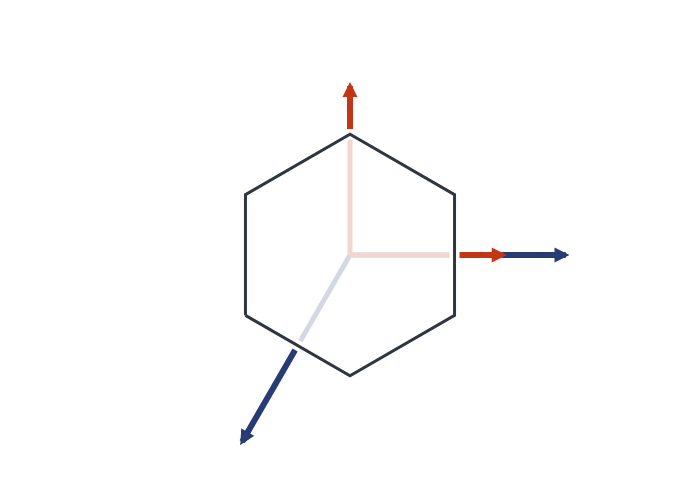

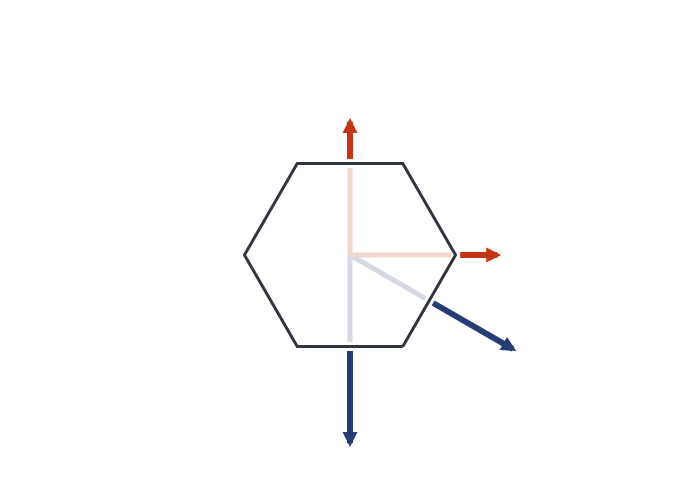

In [2]:
# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]


# Reciprocal and Direct Lattice   R1 and R2 are the basis vectors in the real space ! 
global const R1::Vector{Float64} = [-0.5, -0.5 * sqrt(3.0)]
global const R2::Vector{Float64} = C_3 * R1
global const R3::Vector{Float64} = C_3 * R2;

# Now, the reciprocal lattice 
global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');

let
    print("--- Plotting the Wigner-Seitz cell in real space. \n")
    print("\n")

    As = [R[i, :] for i ∈ 1 : size(R, 1)]
    real_wignerseitz = wignerseitz(As)

    vertices = real_wignerseitz.verts

    print("--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(real_wignerseitz)
    display(pbzb)

end

let
    print("--- Plotting the Wigner-Seitz cell in reciprocal space. \n")
    print("\n")

    G1 = G[1, :]; G2 = G[2, :]
    Gs = [G[i, :] for i ∈ 1 : size(G, 1)]
    recip_wignerseitz = wignerseitz(Gs)

    vertices = recip_wignerseitz.verts

    # Here, we want the cartesian coordinates of the corners (vertices of the FBZ). We also need the cartesian coordinates of the M point 
    global cart_v::Vector{Vector{Float64}} = similar(vertices)
    for i ∈ 1:size(cart_v, 1)
        red_v = vertices[i]
        cart_v[i] = red_v[1] * G1 + red_v[2] * G2
    end

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cart_v
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(recip_wignerseitz)
    display(pbzb)

end

In [3]:

global const cK::SVector{2, Float64} = SVector{2, Float64}(cart_v[2])
global const cK_I::SVector{2, Float64} = @SVector [2.094395, 3.627599]
# Now, the K-Points 
global const high_symmetry_points = Dict{String, SVector{2, Float64}}(
    "K"=> cK, 
    "M"=> (cK + cK_I) / 2.0,
    "Γ"=> [0.0, 0.0] 
)


Dict{String, SVector{2, Float64}} with 3 entries:
  "M" => [3.14159, 1.8138]
  "Γ" => [0.0, 0.0]
  "K" => [4.18879, -8.88178e-16]

### Parameters and Construction of the Hamiltonian 

In the kagome system, there is a periodic pattern of corner-sharing upright triangles and inverted triangles. We want to consider strong Breathing anisotropy. We consider the model 
discussed in Bolens and Nagosa 

In [4]:
struct Params

    # we will use unicode characters to name the variables 

    # Parameters for the upright triangle 
    t1Δ::Float64
    t2Δ::Float64
    t3Δ::Float64
    # Parameters for the inverted triangle 
    t1∇::Float64
    t2∇::Float64
    t3∇::Float64
    

end


### Symmetry 

We will find the constraints imposed by C_3 on possible Bloch Hamiltonians. In the next few code blocks, we define both C_3 and mirror 

In [5]:
## How C_3 rotates the atomic sites 
global const C3_abc::Matrix{Float64} = [0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 1.0 0.0]; 
## Check that it is order 3 (It is a cyclic permutation)
C3_abc^3


3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [6]:
@variables ϕ1 ϕ2 ϕ3 ϕ1c ϕ2c ϕ3c H
H = [0 ϕ1c ϕ3; ϕ1 0 ϕ2c; ϕ3c ϕ2 0]
H

3×3 Matrix{Num}:
   0  ϕ1c   ϕ3
  ϕ1    0  ϕ2c
 ϕ3c   ϕ2    0

In [7]:
## Conjugation of the Hamiltonian by the C3 action 
C3_abc * H * inv(C3_abc)

3×3 Matrix{Num}:
 0.0  ϕ3c   ϕ2
  ϕ3  0.0  ϕ1c
 ϕ2c   ϕ1  0.0

In [8]:
## Mirror M_001
M_001_abc::Matrix{Float64} = [1.0 0.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0]

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  0.0  1.0
 0.0  1.0  0.0

In [9]:
# print k1, k2, k2 
let R1 = R1, R2 = R2, R3 = R3
    @variables k k1 k2 k3 kx ky 
    k = [kx ky]
    k1 = dot(k, R1); k2 = dot(k, R2); k3 = dot(k, R3)
    println("k₁ = ", k1)
    println("k₂ = ", k2)
    println("k₃ = ", k3)
end

k₁ = -0.5kx - 0.8660254037844386ky
k₂ = 0.9999999999999999kx - 2.220446049250313e-16ky
k₃ = -0.49999999999999956kx + 0.8660254037844387ky


We now would like to test whether the breathing anisotropy breaks C2 symmetry. There are many ways to do this. One simple method is to just plot the energies of the model,
and observe whether or not the spectra at C_2 related points are the same. One can also test this directly by diagonalizing the Hamiltonian at a random set of pairs with each pair being on the same C_2 orbit i.e. antipodal pairs (k, -k)

In [10]:
global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

# Implement the Hamiltonian in Nagosa's paper without spin-orbit interaction or magnetism 
@inline function HamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    Hermitian(Ham + Ham')
end

@inline function HamBreathingKagomeNoSOC(k::SVector{2, Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    Hermitian(Ham + Ham')
end


@inline function EvalsHamBreathingKagomeNoSOC(k::SVector{2, Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end

@inline function EvalsHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end

@inline function EigensystemHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigen(Hermitian(Ham + Ham'))
end



EigensystemHamBreathingKagomeNoSOC (generic function with 1 method)

In [11]:
function plot_simple_kagome_bands(;p, seedname, kpath, title = Nothing)
    if title == Nothing
        title = seedname
    end
    eks = EvalsHamBreathingKagomeNoSOC.(kpath, Ref(p))

    nps_x = size(kpath, 1)
    xs = 1 : nps_x
    
    t1 = PlotlyJS.scatter(x = xs, y = map(e->e[1], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t2 = PlotlyJS.scatter(x = xs, y = map(e->e[2], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t3 = PlotlyJS.scatter(x = xs, y = map(e->e[3], eks), mode = "lines", line = attr(color = "purple", width = 4))
    lo = PlotlyJS.Layout(title = title,
                xaxis_showgrid = true,
                yaxis_showgrid = true,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                yaxis = attr(showgrid = true, showticklabels = true, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                width = 510, 
                height = 510,
                showlegend = false)
    
    p = PlotlyJS.plot([t1, t2, t3], lo)
    #PlotlyJS.savefig(p, assets_dir * seedname * ".png")
    display(p)
end

plot_simple_kagome_bands (generic function with 1 method)

t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


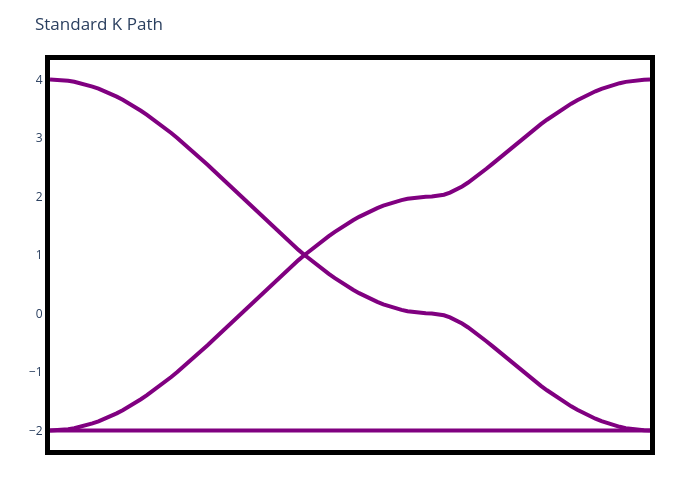

In [12]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "Standard K Path", kpath = kpath_fbz, title = Nothing)
end



t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


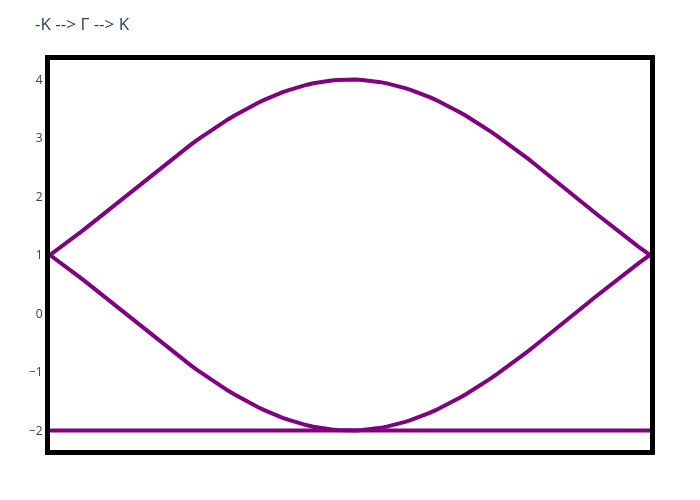

In [13]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.5
t2∇ = 1.5
t3∇ = 1.5


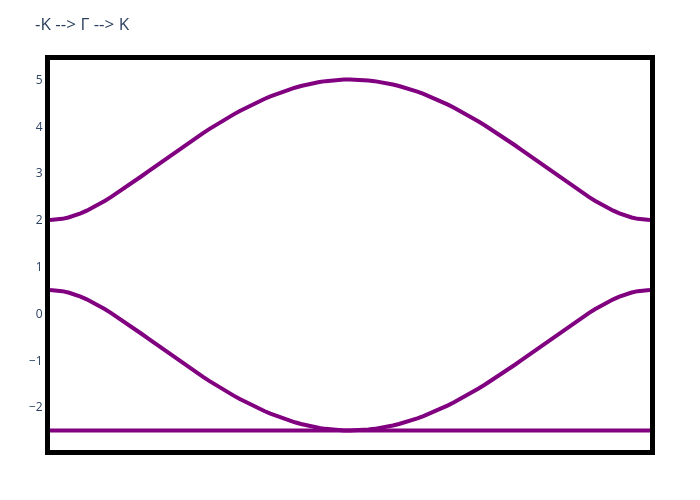

In [14]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.5, t2∇ = 1.5, t3∇ = 1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


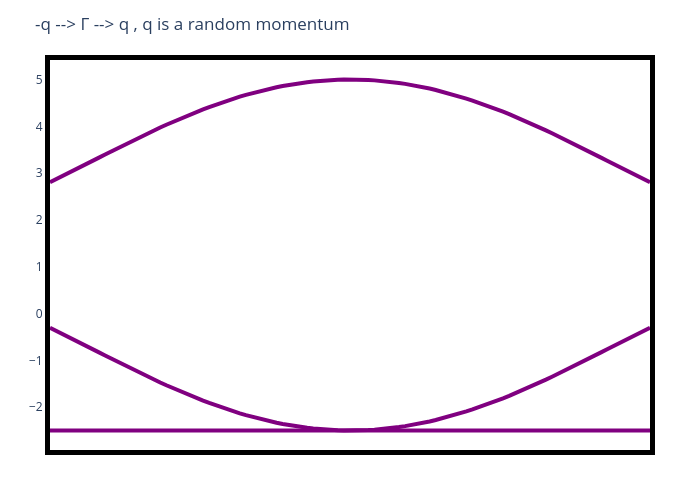

t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.5
t2∇ = 1.5
t3∇ = 1.5


In [15]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.5, t2∇ = 1.5, t3∇ = 1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)

    kpoint = @SVector[3.02, 0.45]
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-kpoint, 
                    high_symmetry_points["Γ"], 
                    kpoint];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-q --> Γ --> q , q is a random momentum", kpath = kpath_fbz, title = Nothing)
end


t1Δ = 1.0
t2Δ = 0.5
t3Δ = 2.0
t1∇ = -1.5
t2∇ = 0.7
t3∇ = -0.3


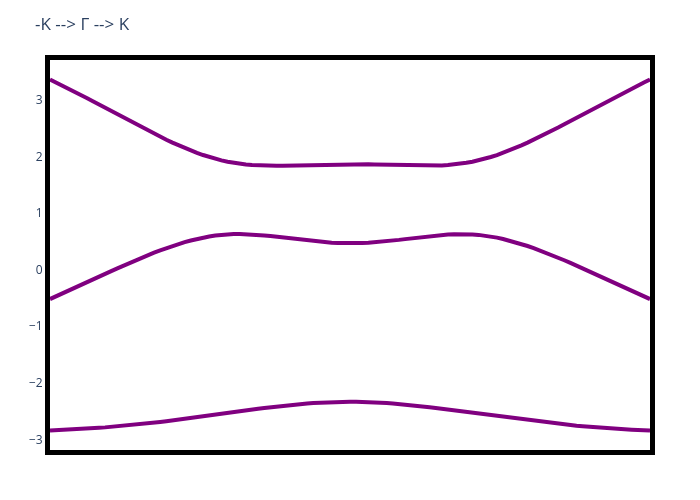

In [16]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 0.5, t3Δ = 2.0, t1∇ = -1.5, t2∇ = 0.7, t3∇ = -0.3
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


The band structure is still invariant under k --> -k. This arises from constraints from other symmetries. So, we need to take account of the full magnetic symmetry group to understand the model. One symmetry is obvious here, which is Time-Reversal symmetry. this forces the spectrum to be invariant as k --> -k 
Also, we note that in two-dimensions, there is no distinction between inversion and C2 (rotation by 180 degrees). We want to consider 1) proper rotations SO(2) and 2) Mirror (Reflections around certain lines), which have determinant -1 , so not topologically connected with elements in SO(2). 

In [17]:
let t1Δ = 1.0, t2Δ = 0.5, t3Δ = 2.0, t1∇ = -1.5, t2∇ = 0.7, t3∇ = -0.3
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    K::Vector{Float64} = high_symmetry_points["K"]
    Γ::Vector{Float64} = high_symmetry_points["Γ"]
    
    (E, U) = EigensystemHamBreathingKagomeNoSOC(K, p)
    (E′, U′) = EigensystemHamBreathingKagomeNoSOC(-K, p)
    U - U′
end


t1Δ = 1.0
t2Δ = 0.5
t3Δ = 2.0
t1∇ = -1.5
t2∇ = 0.7
t3∇ = -0.3


3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0+0.0367317im  0.0-0.23im      0.0-0.276843im
 0.0+0.439593im   0.0-0.922635im  0.0-0.84121im
 0.0+0.0im        0.0+0.0im       0.0+0.0im

In [18]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.5, t2∇ = 1.5, t3∇ = 1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    K::Vector{Float64} = high_symmetry_points["K"]
    Γ::Vector{Float64} = high_symmetry_points["Γ"]
    
    (E, U) = EigensystemHamBreathingKagomeNoSOC(K, p)
    (E′, U′) = EigensystemHamBreathingKagomeNoSOC(-K, p)
    U - U′
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.5
t2∇ = 1.5
t3∇ = 1.5


3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0+1.0im  0.0+1.11022e-15im  0.0+1.0im
 0.0-1.0im  0.0-3.33067e-16im  0.0-1.0im
 0.0+0.0im  0.0+0.0im          0.0+0.0im

In [19]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    K::Vector{Float64} = high_symmetry_points["K"]
    Γ::Vector{Float64} = high_symmetry_points["Γ"]
    
    (E, U) = EigensystemHamBreathingKagomeNoSOC(K, p)
    (E′, U′) = EigensystemHamBreathingKagomeNoSOC(-K, p)
    U - U′
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0+1.0im  0.0+0.707107im  0.0+0.868327im
 0.0-1.0im  0.0-0.707107im  0.0+1.40086im
 0.0+0.0im  0.0+0.0im       0.0+0.0im

In the ideal kagome system, the symmetry generators (ignoring time-reversal symmetry and translation symmetry) are: C2, C3 (together form C6), and a Mirror symmetry. Taking into account translations, this leads to G_0 = p6mm. The mm means that there are two independent mirror lines 

In [20]:
using Random
@inline function TestTimeReversalSymmetrySpinless(;p::Params, nps::Int, tol::Float64 = 1e-4)
    """
    Check whether the system has time-reversal symmetry -- We use the Frobenius norm 
    """
    v = Vector{Float64}(undef, nps)
    rand_kpoints::Vector{SVector{2, Float64}} = [rand(-π:π, 2) for i ∈ 1:nps]
    for (i, k) ∈ enumerate(rand_kpoints)
        v[i] = norm(HamBreathingKagomeNoSOC(k, p) - conj.(HamBreathingKagomeNoSOC(-k, p))) # Frobenius
    end
    res::Float64 = norm(v)
    if (res > tol)
        println("Symmetry is broken, Frobenius norm = ", res)
    else
        println("Symmetry is preserved, Frobenius norm = ", res)
    end
end

@inline function TestC3Symmetry(;p::Params, nps::Int, tol::Float64 = 1e-4)
    """
    Check whether the system has time-reversal symmetry -- We use the Frobenius norm 
    """

    println("\n")
    println("--- Checking C_3 symmetry. ")
    println("\n")

    v = Vector{Float64}(undef, nps)
    rand_kpoints::Vector{SVector{2, Float64}} = [rand(-π:π, 2) for i ∈ 1:nps]
    for (i, k) ∈ enumerate(rand_kpoints)
        v[i] = norm(HamBreathingKagomeNoSOC(k, p) - C3_abc * HamBreathingKagomeNoSOC(C_3' * k, p) * inv(C3_abc)) # Frobenius
        @printf("%-17s %03d %-20s %10.4f\n", "random k-point #", i, "   , Frobenius norm at k-point:", v[i])
    end
    println("\n")
    res::Float64 = norm(v)
    if (res > tol)
        println("Symmetry is broken, Frobenius norm = ", res)
    else
        println("Symmetry is preserved, Frobenius norm = ", res)
    end
end

TestC3Symmetry (generic function with 1 method)

In [21]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    TestTimeReversalSymmetrySpinless(p = p, nps = 100)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0
Symmetry is preserved, Frobenius norm = 0.0


In [22]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    TestC3Symmetry(p = p, nps = 100)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


--- Checking C_3 symmetry. 


random k-point #  001    , Frobenius norm at k-point:     0.0000
random k-point #  002    , Frobenius norm at k-point:     0.0000
random k-point #  003    , Frobenius norm at k-point:     0.0000
random k-point #  004    , Frobenius norm at k-point:     0.0000
random k-point #  005    , Frobenius norm at k-point:     0.0000
random k-point #  006    , Frobenius norm at k-point:     0.0000
random k-point #  007    , Frobenius norm at k-point:     0.0000
random k-point #  008    , Frobenius norm at k-point:     0.0000
random k-point #  009    , Frobenius norm at k-point:     0.0000
random k-point #  010    , Frobenius norm at k-point:     0.0000
random k-point #  011    , Frobenius norm at k-point:     0.0000
random k-point #  012    , Frobenius norm at k-point:     0.0000
random k-point #  013    , Frobenius norm at k-point:     0.0000
random k-point #  014    , Frobenius norm at k-point:     0.000

In [23]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 3.5, t2∇ = 5.5, t3∇ = 0.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    TestC3Symmetry(p = p, nps = 100)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 3.5
t2∇ = 5.5
t3∇ = 0.5


--- Checking C_3 symmetry. 


random k-point #  001    , Frobenius norm at k-point:     8.7178
random k-point #  002    , Frobenius norm at k-point:     8.7178
random k-point #  003    , Frobenius norm at k-point:     8.7178
random k-point #  004    , Frobenius norm at k-point:     8.7178
random k-point #  005    , Frobenius norm at k-point:     8.7178
random k-point #  006    , Frobenius norm at k-point:     8.7178
random k-point #  007    , Frobenius norm at k-point:     8.7178
random k-point #  008    , Frobenius norm at k-point:     8.7178
random k-point #  009    , Frobenius norm at k-point:     8.7178
random k-point #  010    , Frobenius norm at k-point:     8.7178
random k-point #  011    , Frobenius norm at k-point:     8.7178
random k-point #  012    , Frobenius norm at k-point:     8.7178
random k-point #  013    , Frobenius norm at k-point:     8.7178
random k-point #  014    , Frobenius norm at k-point:     8.717

In [24]:
let t1Δ = 1.0, t2Δ = 2.0, t3Δ = 0.7, t1∇ = 0.5, t2∇ = 7.5, t3∇ = -1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    TestC3Symmetry(p = p, nps = 100)
end


t1Δ = 1.0
t2Δ = 2.0
t3Δ = 0.7
t1∇ = 0.5
t2∇ = 7.5
t3∇ = -1.5


--- Checking C_3 symmetry. 


random k-point #  001    , Frobenius norm at k-point:    15.7932
random k-point #  002    , Frobenius norm at k-point:    16.9760
random k-point #  003    , Frobenius norm at k-point:    14.9736
random k-point #  004    , Frobenius norm at k-point:    15.8775
random k-point #  005    , Frobenius norm at k-point:    15.4220
random k-point #  006    , Frobenius norm at k-point:    15.4220
random k-point #  007    , Frobenius norm at k-point:    18.1903
random k-point #  008    , Frobenius norm at k-point:    14.6904
random k-point #  009    , Frobenius norm at k-point:    14.9736
random k-point #  010    , Frobenius norm at k-point:    18.1449
random k-point #  011    , Frobenius norm at k-point:    16.2389
random k-point #  012    , Frobenius norm at k-point:    17.2234
random k-point #  013    , Frobenius norm at k-point:    17.2118
random k-point #  014    , Frobenius norm at k-point:    15.87

In [25]:
let t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 0.5, t2∇ = 0.5, t3∇ = 0.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    TestC3Symmetry(p = p, nps = 100)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 0.5
t2∇ = 0.5
t3∇ = 0.5


--- Checking C_3 symmetry. 


random k-point #  001    , Frobenius norm at k-point:     0.0000
random k-point #  002    , Frobenius norm at k-point:     0.0000
random k-point #  003    , Frobenius norm at k-point:     0.0000
random k-point #  004    , Frobenius norm at k-point:     0.0000
random k-point #  005    , Frobenius norm at k-point:     0.0000
random k-point #  006    , Frobenius norm at k-point:     0.0000
random k-point #  007    , Frobenius norm at k-point:     0.0000
random k-point #  008    , Frobenius norm at k-point:     0.0000
random k-point #  009    , Frobenius norm at k-point:     0.0000
random k-point #  010    , Frobenius norm at k-point:     0.0000
random k-point #  011    , Frobenius norm at k-point:     0.0000
random k-point #  012    , Frobenius norm at k-point:     0.0000
random k-point #  013    , Frobenius norm at k-point:     0.0000
random k-point #  014    , Frobenius norm at k-point:     0.000

## Model with Rashba and Intrinsic Spin-Orbit Coupling

d1, d2, d3 are three unit vectors forming C_3 system. They define both the Rashba and Intrinsic SOC 
t1, t2, t3 are three 2 x 2 matrices in the spin space. 

In [35]:
global const σ₀::Matrix{ComplexF64} = @SMatrix [1.0 0.0; 0.0 1.0]
global const σ₁::Matrix{ComplexF64} = @SMatrix [0.0 1.0; 1.0 0.0]
global const σ₂::Matrix{ComplexF64} = @SMatrix [0.0 -im; im 0.0]
global const σ₃::Matrix{ComplexF64} = @SMatrix [1.0 0.0; 0.0 -1.0]

struct ParamsSOCModel

    # we will use unicode characters to name the variables 

    # Parameters for the upright triangle 
    
    # Orbital Hoppings 
    t1Δ::Float64
    t2Δ::Float64
    t3Δ::Float64
    # Intrinsic Spin orbit coupling (Kane-Mele type)
    λI1Δ::Float64
    λI2Δ::Float64
    λI3Δ::Float64
    # Rashba Spin orbit coupling (Breaks mirror )
    λR1Δ::Float64
    λR2Δ::Float64
    λR3Δ::Float64

    # Parameters for the upside down triangle 
    
    # Orbital Hoppings 
    t1∇::Float64
    t2∇::Float64
    t3∇::Float64
    # Intrinsic Spin orbit coupling (Kane-Mele type)
    λI1∇::Float64
    λI2∇::Float64
    λI3∇::Float64
    # Rashba Spin orbit coupling (Breaks mirror )
    λR1∇::Float64
    λR2∇::Float64
    λR3∇::Float64

    # phi and theta 
    ϕ::Float64
    θ::Float64
    

end



@inline d̂₁ = θ -> SVector{3, Float64}(cos(θ) * sqrt(3.0)/2.0, -0.5 * cos(θ), sin(θ))
@inline d̂₂ = θ -> SVector{3, Float64}(0.0, cos(θ), sin(θ))
@inline d̂₃ = θ -> SVector{3, Float64}(cos(θ) * sqrt(3.0)/2.0, 0.5 * cos(θ), sin(θ))

@inline t̂₁ = (ϕ, θ, t, λI, λR) -> SMatrix{2, 2, ComplexF64}((cos(ϕ) * σ₀ +
             im * sin(ϕ) * (d̂₁(θ)[1] * σ₁ + d̂₁(θ)[2] * σ₂ + d̂₁(θ)[3] * σ₃)) * sqrt(t^2 + λI^2 + λR^2))

@inline t̂₂ = (ϕ, θ, t, λI, λR) -> SMatrix{2, 2, ComplexF64}((cos(ϕ) * σ₀ +
             im * sin(ϕ) * (d̂₂(θ)[1] * σ₁ + d̂₂(θ)[2] * σ₂ + d̂₂(θ)[3] * σ₃)) * sqrt(t^2 + λI^2 + λR^2))

@inline t̂₃ = (ϕ, θ, t, λI, λR) -> SMatrix{2, 2, ComplexF64}((cos(ϕ) * σ₀ +
             im * sin(ϕ) * (d̂₃(θ)[1] * σ₁ + d̂₃(θ)[2] * σ₂ + d̂₃(θ)[3] * σ₃)) * sqrt(t^2 + λI^2 + λR^2))


# Implement the Hamiltonian in Nagosa's paper without spin-orbit interaction or magnetism 
@inline function HamBreathingKagomeSOC(k::Vector{Float64}, p::ParamsSOCModel)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{6, 6, ComplexF64} = kron(t̂₁(p.ϕ, p.θ, p.t1Δ, p.λI1Δ, p.λR1Δ)' + exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky)) * t̂₁(p.ϕ1, p.θ1, p.t1∇, p.λI1∇, p.λR1∇)', T1u) +
        kron(t̂₃(p.ϕ, p.θ, p.t3Δ, p.λI3Δ, p.λR3Δ) + exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky)) * t̂₃(p.ϕ, p.θ, p.t3∇, p.λI3∇, p.λR3∇), T2u) +
        kron(t̂₂(p.ϕ, p.θ, p.t2Δ, p.λI2Δ, p.λR2Δ)' + exp(-im * kx) * t̂₂(p.ϕ, p.θ, p.t2∇, p.λI2∇, p.λR2∇)', T3u)
    Hermitian(Ham + Ham')
end

@inline function EvalsBreathingKagomeSOC(k::Vector{Float64}, p::ParamsSOCModel)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{6, 6, ComplexF64} = kron(t̂₁(p.ϕ, p.θ, p.t1Δ, p.λI1Δ, p.λR1Δ)' + exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky)) * t̂₁(p.ϕ, p.θ, p.t1∇, p.λI1∇, p.λR1∇)', T1u) +
        kron(t̂₃(p.ϕ, p.θ, p.t3Δ, p.λI3Δ, p.λR3Δ) + exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky)) * t̂₃(p.ϕ, p.θ, p.t3∇, p.λI3∇, p.λR3∇), T2u) +
        kron(t̂₂(p.ϕ, p.θ, p.t2Δ, p.λI2Δ, p.λR2Δ)' + exp(-im * kx) * t̂₂(p.ϕ, p.θ, p.t2∇, p.λI2∇, p.λR2∇)', T3u)
    eigvals(Hermitian(Ham + Ham'))
end


EvalsBreathingKagomeSOC (generic function with 1 method)

Next, we plot the band structure using the Hamiltonian in the prev. block 


In [36]:
function plot_SOC_6x6_kagome_bands(;p, seedname, kpath, title = Nothing)
    if title == Nothing
        title = seedname
    end
    eks = EvalsBreathingKagomeSOC.(kpath, Ref(p))

    nps_x = size(kpath, 1)
    xs = 1 : nps_x
    
    t1 = PlotlyJS.scatter(x = xs, y = map(e->e[1], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t2 = PlotlyJS.scatter(x = xs, y = map(e->e[2], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t3 = PlotlyJS.scatter(x = xs, y = map(e->e[3], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t4 = PlotlyJS.scatter(x = xs, y = map(e->e[4], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t5 = PlotlyJS.scatter(x = xs, y = map(e->e[5], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t6 = PlotlyJS.scatter(x = xs, y = map(e->e[6], eks), mode = "lines", line = attr(color = "purple", width = 4))
    lo = PlotlyJS.Layout(title = title,
                xaxis_showgrid = true,
                yaxis_showgrid = true,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                yaxis = attr(showgrid = true, showticklabels = true, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                width = 510, 
                height = 510,
                showlegend = false)
    
    p = PlotlyJS.plot([t1, t2, t3, t4, t5, t6], lo)
    #PlotlyJS.savefig(p, assets_dir * seedname * ".png")
    display(p)
end

plot_SOC_6x6_kagome_bands (generic function with 1 method)

t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


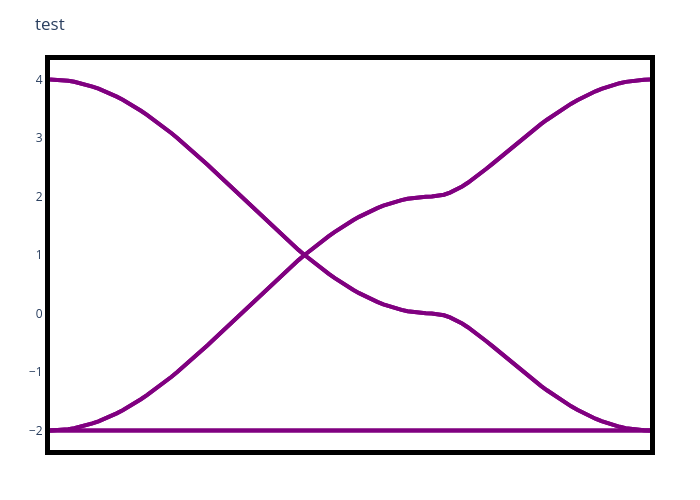

In [41]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0,
    λI1Δ = 0.0, λI2Δ = 0.0, λI3Δ = 0.0, λI1∇ = 0.0, λI2∇ = 0.0, λI3∇ = 0.0,
    λR1Δ = 0.0, λR2Δ = 0.0, λR3Δ = 0.0, λR1∇ = 0.0, λR2∇ = 0.0, λR3∇ = 0.0,
    ϕ = 0.0, θ = 0.0

    p::ParamsSOCModel = ParamsSOCModel(t1Δ, t2Δ, t3Δ, λI1Δ, λI2Δ, λI3Δ, λR1Δ, λR2Δ, λR3Δ,
    t1∇, t2∇, t3∇, λI1∇, λI2∇, λI3∇, λR1∇, λR2∇, λR3∇, ϕ, θ)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_SOC_6x6_kagome_bands(;p = p, seedname = "test", kpath = kpath_fbz, title = Nothing)
end
